In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, cos, symbols, diff, sqrt
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [2]:
# accuracy and range of x, y, and t
x_i, x_f = (0,1)
y_i, y_f = (0,1)
t_i, t_f = (0,1)

L_x = x_f - x_i
L_y = y_f - y_i

x_points = 10
y_points = 10
t_points = 500

# variables that will be used later
x_delta = (x_f - x_i) / (x_points - 1)
y_delta = (y_f - y_i) / (y_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
y = np.linspace(y_i, y_f, y_points)
t = np.linspace(t_i, t_f, t_points)

nodes = x_points * y_points
nonboundary_nodes = (x_points - 2) * (y_points - 2)

# animation settings
duration = 5
animation_interval = 1000 * duration / t_points # t_points = frames
repeat_delay = 100000
cmap = 'Wistia'

In [3]:
# Convection-Diffusion Equation
xv, yv = np.meshgrid(x, y)
xt, yt, tt = np.meshgrid(x, y, t)
x_symbol, y_symbol, t_symbol = symbols('x y t')

# dT/dt = a * d2T/dx2 - ε * u * dT/dx + Q / cp
# this is a 1D simplificiation (only x and t); u is 
# the velocity feild, Q represents any sources
# all other (non-derivative) terms are constants

a = -.0025
e = 1 # this is ε
Q = 0
c = 1 # c = cp bc both are constants 

# treating u as an input 
v_field = 5 * x_symbol
1/2
u_x = -2 * (y_symbol - L_x / 2)
u_y = 2 * x_symbol - L_y / 2

u_x /= sqrt((x_symbol - L_x / 2.0) ** 2.0 + (y_symbol - L_y / 2.0) ** 2.0)
u_y /= sqrt((x_symbol - L_x / 2.0) ** 2.0 + (y_symbol - L_y / 2.0) ** 2.0)

u_x = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], u_x))
u_y = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], u_y))

Q = np.vectorize(lambdify([x_symbol, y_symbol, t_symbol], Q))
Q_mat = np.array([Q(xv, yv, curr_t) for curr_t in t])

print(t_delta / (x_delta ** 2) + t_delta / (y_delta ** 2))

0.3246492985971944


In [4]:
# boundary and initial conditions
scale_factor = 10
alpha = 70

f_0 = exp(- alpha * ((x_symbol - L_x / 2.0) ** 2.0 + (y_symbol - L_y / 4.0) ** 2.0))
f_0 = np.vectorize(lambdify([x_symbol, y_symbol], f_0))

init_distribution = f_0(xv, yv).flatten()

# boundary conditions
T_1 = 0
T_2 = 0

# defining if y is a dirichlet or neumann boundary condition
y_is_dirichlet = True

# lower boundary condition (x = x_i or y = y_i)
x_0 = T_1
x_0 = np.vectorize(lambdify([y_symbol], x_0))

if y_is_dirichlet: y_0 = T_1 + (T_2 - T_1) * x_symbol / L_x
else: y_0 = 0 # y_0 is y_0_deriv

y_0 = np.vectorize(lambdify([x_symbol], y_0))

# upper boundary condtions (x = x_f or y = y_f)
x_L = T_2
x_L = np.vectorize(lambdify([y_symbol], x_L))

if y_is_dirichlet: y_L = T_1 + (T_2 - T_1) * x_symbol / L_x
else: y_L = 0 # y_L is y_L_deriv

y_L = np.vectorize(lambdify([x_symbol], y_L))

In [5]:
# code for generating animations
from matplotlib.ticker import MaxNLocator

def gen_anim(data, file_name):
    fig, ax = plt.subplots(1, 1, figsize = (6,6), subplot_kw={"projection": "3d"})

    data = np.reshape(data, (t_points, x_points * y_points))

    max_z = np.max(data)
    min_z = np.min(data)
    
    print(f"max : {max_z}, min : {min_z}")

    def animate(i):
        ax.cla()
        trisurf = ax.plot_trisurf(xv.flatten(), yv.flatten(), data[i-1], cmap = plt.get_cmap(cmap))
        ax.set_xlim((x_i, x_f))
        ax.set_ylim((y_i, y_f))
        ax.set_zlim((min_z, max_z))

    # formatting the graph
    ax.view_init(25, 45, 0)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    fig.tight_layout()

    anim = animation.FuncAnimation(fig, animate, frames = t_points, interval = animation_interval, blit = False, repeat_delay = repeat_delay)
    anim.save(file_name)

In [6]:
# Laplacian Matrix
fd_coeffs = {1 : [[-3/2, 2, -1/2], [-1/2, 0, 1/2], [1/2, -2, 3/2]], 2 : [[2, -5, 4, -1], [1, -2, 1], [-1, 4, -5, 2]]}
delta_powers = {1 : (1, 1, 1), 2: (3, 2, 3)}

def derivative_1d(points : int, delta : float, order = int):
    forward, central, backward = fd_coeffs[order]
    delta_power = delta_powers[order]

    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+ len(central) - 1] = [x / delta ** delta_power[1] for x in central]
    
    mat[0][0:len(forward)] = [x / delta ** delta_power[0] for x in forward]
    mat[-1][-len(backward):] = [x / delta ** delta_power[2] for x in backward]

    return mat

A = np.kron(derivative_1d(y_points, y_delta, 2), np.eye(x_points)) + np.kron(np.eye(y_points), derivative_1d(x_points, x_delta, 2))
C_y = np.kron(derivative_1d(y_points, y_delta, 1), np.eye(x_points))
C_x = np.kron(np.eye(y_points), derivative_1d(x_points, y_delta, 1))

# for some reason this matrix differs from the original in the other file by about ~.00000000000001 around the central diagonal
# this is probably because of the float division errors, but hopefully it won't matter

In [7]:
# function to set the boundary points
def bp(u):
    if y_is_dirichlet:
        u[0:x_points] = y_0(x)
        u[-x_points:] = y_L(x)
    else:
        index = 0
        # y_0 and y_L are y_0_deriv and y_L_deriv
        for y_deriv in y_0(x):
            u[index] = (4 * u[index + x_points] - u[index + 2 * x_points] + y_deriv * y_delta * 2) / 3
            index += 1
        
        index = (y_points - 1) * x_points
        for y_deriv in y_L(x):
            u[index] = (4 * u[index - x_points] - u[index - 2 * x_points] + y_deriv * y_delta * 2) / 3
            index += 1

    index = 0
    for x_val in x_0(y):
        u[index] = x_val
        index += x_points

    index = x_points - 1
    for x_val in x_L(y):
        u[index] = x_val
        index += x_points

    return u

In [8]:
# test = (C_y @ init_distribution).reshape((x_points, y_points))
# # test = init_distribution.reshape((x_points, y_points))

# test = u_y(xv, yv, 0).flatten() * (C_y @ init_distribution)

# plt.imshow(test)
# plt.colorbar()

MovieWriter ffmpeg unavailable; using Pillow instead.


max : 6.307910924099931, min : -7.959669365508777


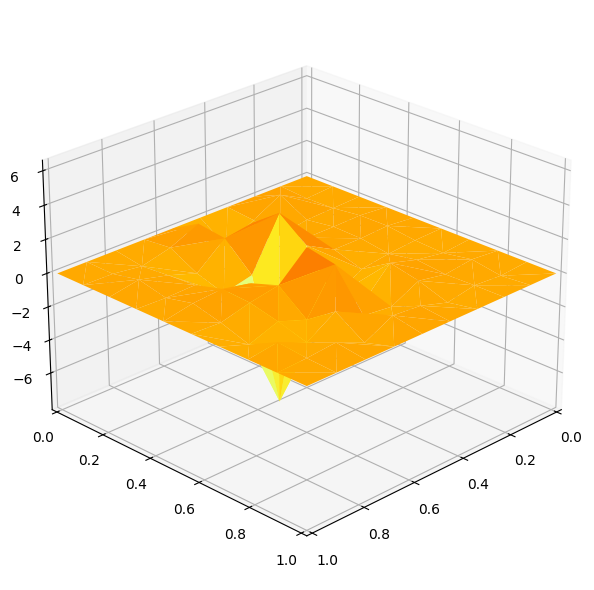

In [9]:
# u_i,j_m+1 = u_i,j_m + a * dt * A @ u_m recursively
u = init_distribution
u_mat = np.zeros((t_points, x_points * y_points))
u_mat[0] = init_distribution

index = 0

for curr_t in t[:-1]:
    d_2 = a * (A @ u)
    d_1_x = e * u_x(xv, yv, curr_t).flatten() * (C_x @ u)
    d_1_y = e * u_y(xv, yv, curr_t).flatten() * (C_y @ u)
    d_0 = Q(xv, yv, curr_t).flatten() / c

    u += t_delta * (d_2 + -d_1_x - d_1_y + d_0)
    u = bp(u)

    u_mat[index := index + 1] = u.flatten()

gen_anim(u_mat, 'tmp/approximate_solution_2d.gif')